<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цель проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование количества заказов такси

## Цель проекта


Необходимо спрогнозировать количество заказов такси в аэропортах на следующий час в зависимости от исторических данных.  Метрикой качества модели будет выступать показатель *RMSE*. По требованию заказчика значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

На основании предложенной модели можно будет оптимизировать число привлекаемых водителей, и, как следствие, улучшить финансовые результаты компании.

Для реализации поставленной задачи следует:

1. Загрузить данные и, при необходимости, выполнить их ресемплирование по одному часу;
2. Проанализировать данные (монотонность, тренд и сезонность и т.п.).
3. Обучить несколько типов моделей с различными гиперпараметрами, выбрать наилучшую.
4. Проверить качество выбранной модели на тестовой выборке и сделать выводы.

In [1]:
# Импорт используемых библиотек:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import warnings

## Подготовка данных

In [2]:
# Загрузка и первичный обзор данных:
try:
    df = pd.read_csv('C:/Users/1/python/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)                                               # упорядочиваем по дате
df.info()
print('Монотонность данных:', df.index.is_monotonic_increasing)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Монотонность данных: True


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Исходный датасет представлен временным рядом из ок. 26 500 наблюдений, с 1 марта 00:00 по 31 августа 23:50 2018 г. Данные следуют с интервалом в 10 мин. Пропусков в данных нет. Выполним ресемплинг по 1 часу.   

In [4]:
# Выполняем ресемплинг:
df = df.resample('1H').sum()
df.head()
print('Размер датасета посде ресемплинга:', df.shape)

Размер датасета посде ресемплинга: (4416, 1)


## Анализ данных

Рассмотрим динамику среднесуточного числа заказов в час (под сутками понимается временной интревал в 24 часа):

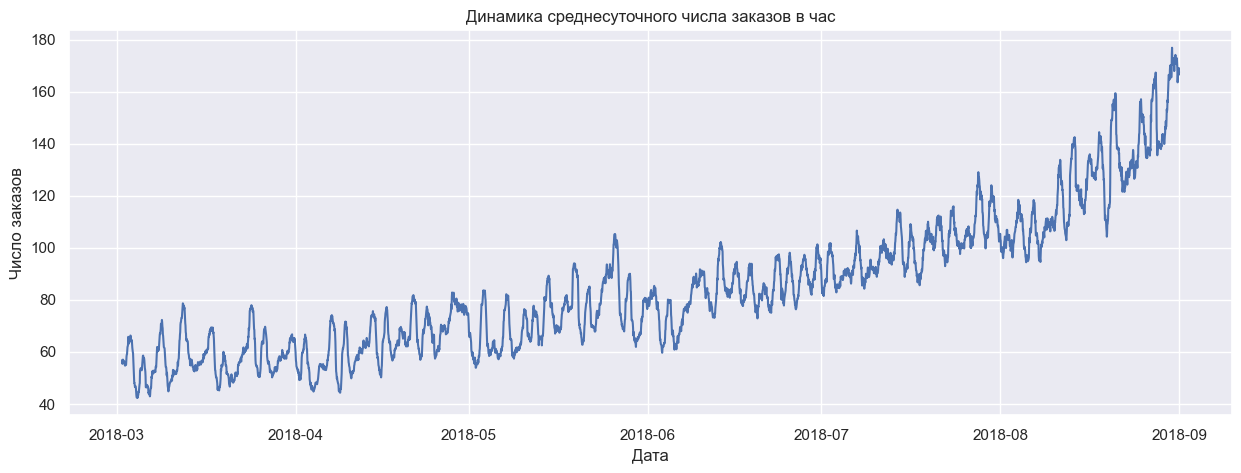

In [5]:
sns.set()
# Динамика скользящего среднего по 24 ч.:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=df.rolling(24).mean(), 
                 legend=False)
ax.set(title ='Динамика среднесуточного числа заказов в час', 
      xlabel = 'Дата',
      ylabel = 'Число заказов')
plt.show()

В данных заметен положительный тренд от марта к августу (из текущих данных нельзя однозначно сказать, связан ли он с ростом числа пользователей такси в целом, либо с сезоном отпусков в летний период), а также сезонные колебания, т.е. ряд не стохастический. Декомпозируем ряд:

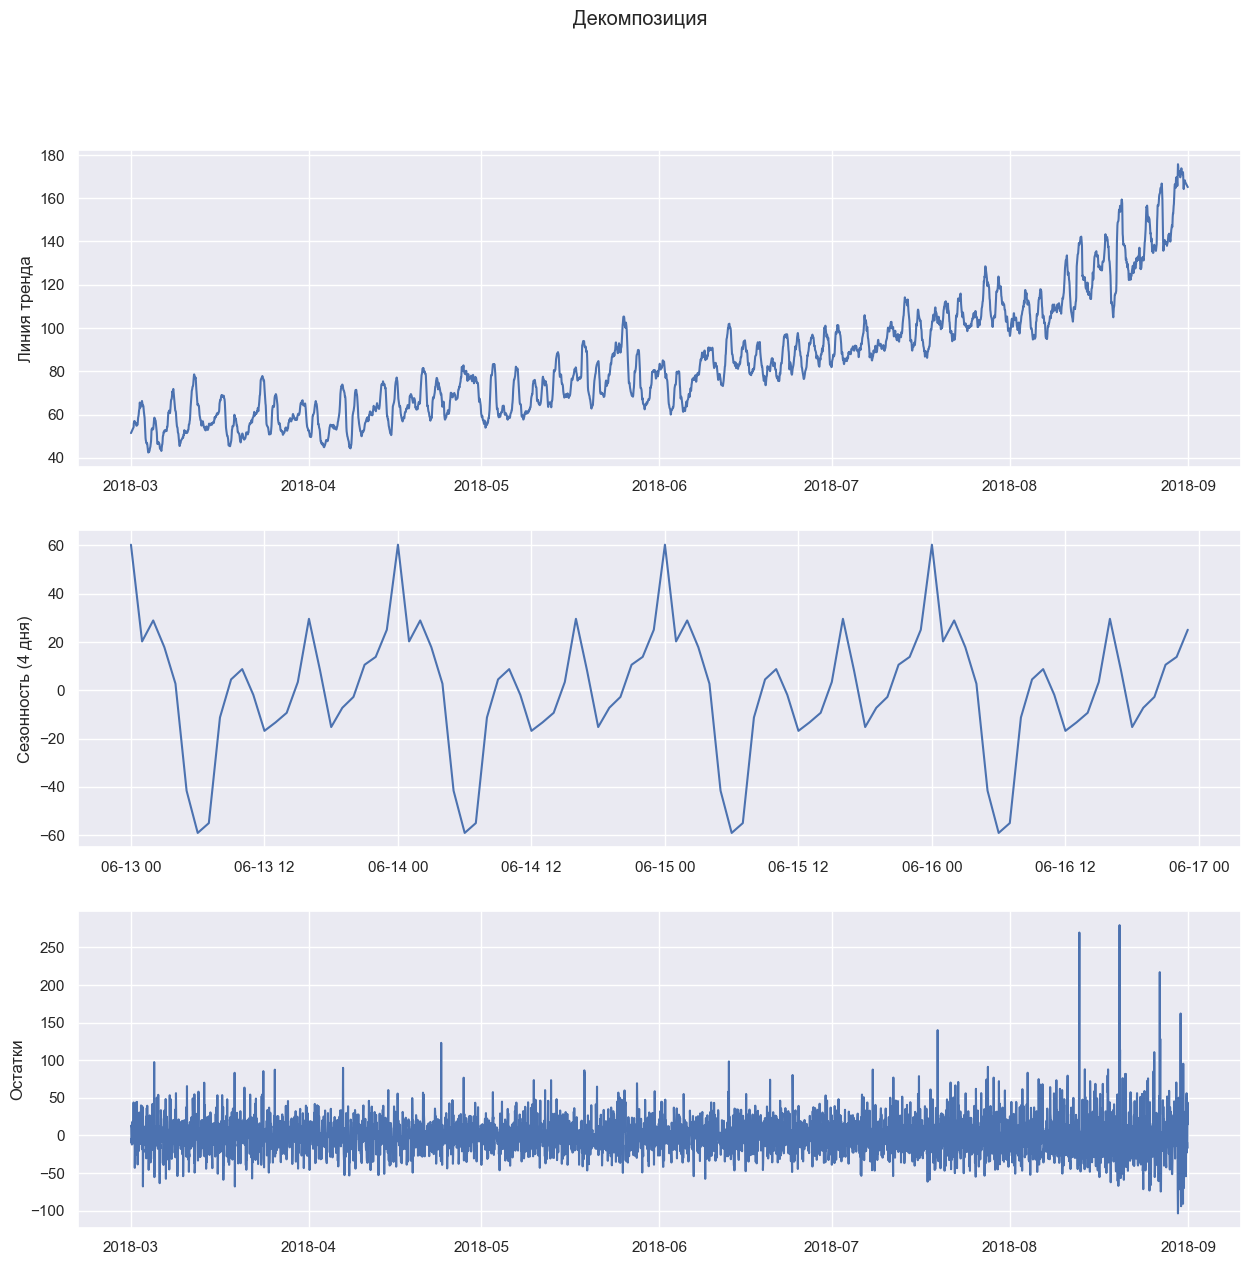

In [6]:
# Декомпозируем:
decomposition = seasonal_decompose(df['num_orders'], extrapolate_trend = 24)
# Визуализация:
fig, axs = plt.subplots(3, 1, figsize=(15, 14))
axs[0].plot(decomposition.trend)
axs[0].set_ylabel('Линия тренда')
axs[1].plot(decomposition.seasonal['2018-06-13':'2018-06-16'])  # Для примера взят интервал в 4 дня
axs[1].set_ylabel('Сезонность (4 дня)')
axs[2].plot(decomposition.resid)
axs[2].set_ylabel('Остатки')
fig.suptitle('Декомпозиция')
plt.show()

Заметна дневная сезонность числа заказов: максимальное количество заказов приходится на ночные часы (когда хуже работает общественный транспорт), минимум - на раннее утро (4-5 утра). Остатки представлены стохастических рядом.

## Исследование моделей

### Подготовка выборок

Сформируем набор признаков для обучения модели. В качестве признаков предлагается использовать год, месяц (гипотетически, в летние месяцы и январе заказов должно быть больше, т.к. люди улетают в отпуск) и день недели (предположительно, заказов в выходные больше, чем в будни). В качестве признака можно также использовать скользящее среднее (напр., среднеднесуточное число заказов в час) и прошлые значения признаков. Для масштабируемости выведем формирование признаков в отдельную функцию:

In [7]:
# Функция для формирования признаков:
def make_features(data, n_lags, rolling_mean_size):
    new_df = data.copy()
    new_df['year'] = new_df.index.year
    new_df['month'] = new_df.index.month
    new_df['weekday'] = new_df.index.dayofweek
    
    for lag in range(1, n_lags + 1):
        new_df['lag_{}'.format(lag)] = new_df.iloc[:, 0].shift(lag)
    
    new_df['rolling_mean'] = new_df.iloc[:, 0].rolling(rolling_mean_size, closed='left').mean()
    return new_df

In [8]:
# Сформируем признаки на датасете:
df = make_features(df, 24, 24)
df = df.dropna()

display(df.head())
print('Размер датасета после формирования признаков:', df.shape)

,num_orders,year,month,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,2018,3,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2018,3,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,2018,3,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,2018,3,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Размер датасета после формирования признаков: (4392, 29)


Теперь, когда признаки подготовлены, разделим данные на обучающую и тестовую выборки:

In [9]:
# Разделяем выборки:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
# Выделяем целевой признак:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print('Обучающая выборка от {0} до {1}.'.format(train.index.min(), train.index.max()))
print('Тестовая выборка от {0} до {1}.'.format(test.index.min(), test.index.max()))

Обучающая выборка от 2018-03-02 00:00:00 до 2018-08-13 15:00:00.
Тестовая выборка от 2018-08-13 16:00:00 до 2018-08-31 23:00:00.


### Обучение моделей

Обучим три типа моделей - линейная регрессия с регуляризацией (lasso; регуляризация необходима, т.к. признаки сильно скоррелированы между собой), случайный лес и градиентный бустинг - и сравним их качество. Для кросс-валидации будем использовать метод прямой цепочки (forward chaining), т.к. методы, основанные на перемешивании выборки, не подходят для временных рядов.

In [10]:
warnings.filterwarnings('ignore')
# Задаем кросс-валидатор:
tscv = TimeSeriesSplit(n_splits=10)

#Задаем словари для цикла:
estimators = {'Регрессия-лассо' : Lasso(),                                # Исследуемые модели
             'Случайный лес' : RandomForestRegressor(),
             'Градиентный бустинг' : LGBMRegressor()}

parameters = {'Регрессия-лассо' : {'alpha': [0.5, 1, 2, 5]},                 # Возможные гиперпараметры
             'Случайный лес' : {'max_features' : ['sqrt', 'log2', None],
                               'max_depth' : range(2, 15)},
             'Градиентный бустинг' : {'learning_rate' : [0.1, 0.3, 0.5, 1],
                                     'n_estimators' : [100, 200, 300],
                                     'max_depth' : range(2, 15)}
             }
best_models = {'Регрессия-лассо' : None,                                    # Обученная лучшая модель
              'Случайный лес' : None,
              'Градиентный бустинг' : None}

results = {'Регрессия-лассо' : None,                                        # Результаты всех обученных моделей
          'Случайный лес' : None,
          'Градиентный бустинг' : None}

best_results = pd.Series(index=estimators.keys())

In [11]:
%%time
# Обучаем модели:
for est in estimators.keys():
    grid = GridSearchCV(estimator=estimators[est],
                       param_grid = parameters[est],
                       scoring = 'neg_root_mean_squared_error',
                       cv=tscv)
    grid.fit(features_train, target_train)
    results[est] = grid.cv_results_['mean_test_score'] * (-1)            # валидация по отриц.величине
    best_models[est] = grid.best_estimator_
    best_results[est] = -grid.best_score_                             

print('RMSE лучших моделей своего типа:')
display(best_results)

RMSE лучших моделей своего типа:


Регрессия-лассо        26.476575
Случайный лес          24.656042
Градиентный бустинг    24.442593
dtype: float64

CPU times: total: 42min
Wall time: 9min 31s


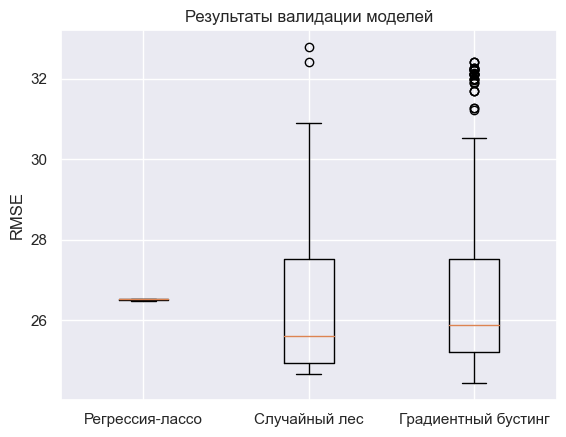

In [12]:
plt.boxplot(results.values(), labels=results.keys())
plt.title('Результаты валидации моделей')
plt.ylabel('RMSE')
plt.show()

Наилучшее значение *RMSE* показала модель градиентного бустинга, хотя ее результаты более дисперсные по сравнению со случайным лесом. Вероятно, дисперсия *RMSE* на кросс-валидации связана с набором исследуемых гиперпараметров. Качество лучшей модели случайного леса незначительно уступает градиентному бустингу. Таким образом, предлагается использовать модель **градиентного бустинга** с гиперпараметрами:

In [13]:
best_models['Градиентный бустинг'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Тестирование

Проверим качество выбранной модели на тестовой выборке:

RMSE для градиентного бустинга на тестовой выборке: 41.18940891329263


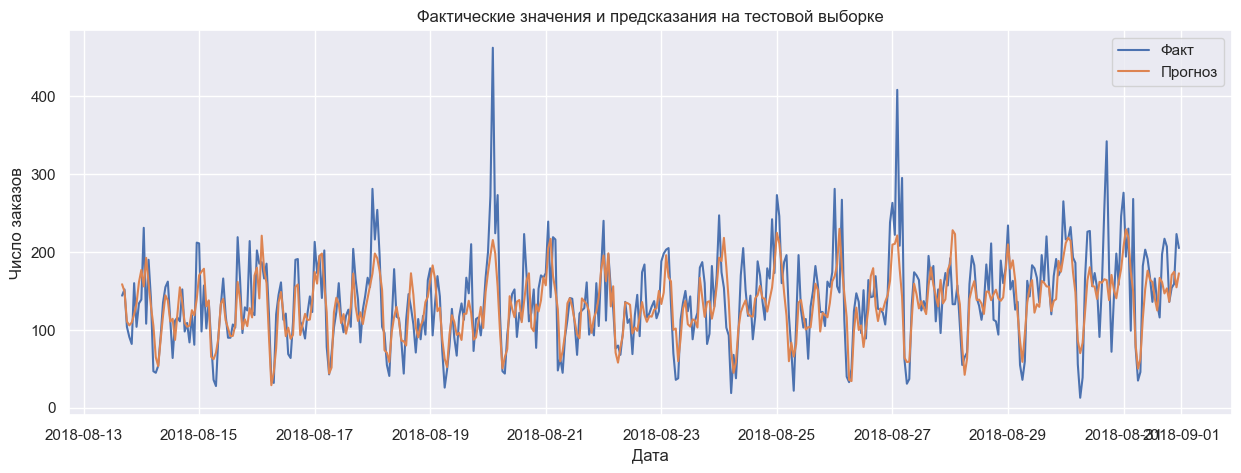

In [14]:
# RMSE на тестовой выборке:
pred_test = best_models['Градиентный бустинг'].predict(features_test)
print('RMSE для градиентного бустинга на тестовой выборке:', mean_squared_error(target_test,
                                                                                pred_test,
                                                                                squared=False)
     )
# Графики прогноза и фактического значения:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data = target_test)                                      # факт
sns.lineplot(x = target_test.index,                                        # прогноз
            y = pred_test,
            ax = ax)
ax.set(title ='Фактические значения и предсказания на тестовой выборке', 
      xlabel = 'Дата',
      ylabel = 'Число заказов')
plt.legend(['Факт', 'Прогноз'])
plt.show()

## Общий вывод

Цель проекта состояла в построении модели, предсказывающей количество заказов такси в аэропорты на следующий час на основе исторических данных.

Исходный датасет был представлен числом заказов за 10 минут с 1 марта 2018 г. (00:00) до 31 августа 2018 г. (23:50). Для дальнейшего анализа данные были конвертированы в число заказов в час. В данных наблюдается восходящий тренд, а также суточная сезонность: наибольшее число заказов размещается в ночные часы, наименьшее - ранним утром.

Для прогноза использовались год, месяц и день недели, а также суточный лаг (каждый час за прошедшие 24 ч.) и среднесуточное число заказов в час. Были изучены три типа моделей: линейная регрессия с регуляризацией, случайный лес и градиентный бустинг. Наилучший результат показала модель **градиентного бустинга** с гиперпараметрами:

- максимальная глубина дерева - 7,
- шаг обучения - 0,1,
- 100 итераций.

Значение *RMSE* на тестовой выборке составило ок. 41,2.